# 9.1 Map equation centrality

In [1]:
%matplotlib inline

from infomap import Infomap
from typing import Dict, Set

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
sns.set_palette(sns.color_palette("colorblind"))

In [3]:
def mkPartition( infomap
               ) -> Dict[int, Set[str]]:
    """
    Extracts a partition from an infomap instance.

    Parameters
    ----------
    infomap 
        An infomap instance. We assume that it has been run so that
        we can actually extract a partition from it.

    Returns
    -------
    Dict[int, Set[str]]
        The networks partition calculated by the given infomap instance
        with community IDs as keys and sets of node labels as values.
        (Assuming that nodes were added with strings as IDs to Infomap.)
    """
    communities = dict()
    for node_ID, community in infomap.get_modules(depth_level = -1).items():
        if not community in communities:
            communities[community] = set()
        communities[community].add(infomap.get_name(node_ID))

    return communities

Many centrality scores take a local or global perspective and derive node centralities either from node features, such as node degrees, or global patterns, such as shortest paths. Map equation centrality takes a modular perspective and derives node centralities from a node's flow and the flow of its module.

In [4]:
G = nx.Graph()
G.add_edges_from([ (1,2), (1,3), (1,4), (2,4), (3,4) # left module
                 , (4,5)                             # bridge
                 , (5,6), (5,7), (5,8), (6,7)        # right module
                 ])

In [5]:
# hand-crafted layout
pos = { 1 : [1,2]
      , 2 : [0,1]
      , 3 : [1,0]
      , 4 : [2,1]
      , 5 : [3,1]
      , 6 : [4,2]
      , 7 : [4,1]
      , 8 : [4,0]
      }

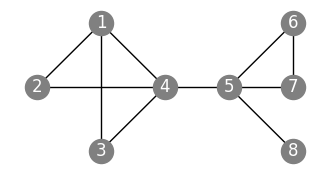

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (4,2))
nx.draw_networkx_nodes(G, pos = pos, node_color = "grey")
nx.draw_networkx_edges(G, pos = pos)
nx.draw_networkx_labels(G, pos = pos, font_color = "white")
ax.axis("off")
plt.show()

Some centrality scores, such as degree centrality and PageRank, consider nodes 4 and 5 equally important.

In [7]:
pd.concat( [ pd.DataFrame(index = sorted(G.nodes))
           , pd.Series(nx.algorithms.centrality.degree_centrality(G), name = "degree centrality")
           , pd.Series(nx.algorithms.centrality.betweenness_centrality(G), name = "betweenness centrality")
           , pd.Series(nx.pagerank(G, alpha = 1), name = "PageRank")
           ]
         , axis = 1
         )

,degree centrality,betweenness centrality,PageRank
1,0.428571,0.023810,0.149994
2,0.285714,0.000000,0.099996
3,0.285714,0.000000,0.099996
4,0.571429,0.595238,0.199995
5,0.571429,0.666667,0.200007
6,0.285714,0.000000,0.100005
7,0.285714,0.000000,0.100005
8,0.142857,0.000000,0.050002


Map equation centrality can distinguish between these nodes by considering their modular context.

In [8]:
# map equation centrality becomes a local measure when we assign all nodes to the same module because this gives all nodes the same modular context
im_one_level = Infomap(silent = True, no_infomap = True)
node_mapping = im_one_level.add_networkx_graph(G)
im_one_level.run()

one_level_centralities = pd.Series({ node_mapping[node.node_id] : node.modular_centrality for node in im_one_level.iterLeafNodes()}, name = "$M_1$")

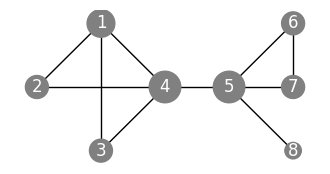

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (4,2))
nodelist = sorted(G.nodes)
nx.draw_networkx_nodes(G, pos = pos, node_color = "grey", nodelist = nodelist, node_size = [2000*one_level_centralities.loc[node] for node in nodelist])
nx.draw_networkx_edges(G, pos = pos)
nx.draw_networkx_labels(G, pos = pos, font_color = "white")
ax.axis("off")
plt.show()

In [10]:
# nodes 4 and 5 have the same centrality if we ignore modules
one_level_centralities.sort_values(ascending = False)

4    0.257542
5    0.257542
1    0.199295
2    0.136803
3    0.136803
6    0.136803
7    0.136803
8    0.070301
Name: $M_1$, dtype: float64

In [11]:
# centralities for the "optimal" partition as identified by Infomap
im = Infomap(silent = True, two_level = True, num_trials = 100)
node_mapping = im.add_networkx_graph(G)
im.run()

optimal_centralities = pd.Series({ node_mapping[node.node_id] : node.modular_centrality for node in im.iterLeafNodes() }, name = "$M_{opt}$")
optimal_modules = dict(im.modules)

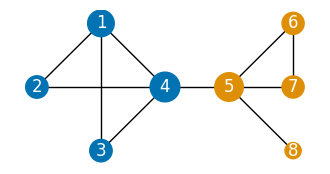

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (4,2))
nodelist = sorted(G.nodes)
nx.draw_networkx_nodes(G, pos = pos, node_color = [sns.color_palette()[optimal_modules[node]-1] for node in nodelist], nodelist = nodelist, node_size = [2000*optimal_centralities.loc[node] for node in nodelist])
nx.draw_networkx_edges(G, pos = pos)
nx.draw_networkx_labels(G, pos = pos, font_color = "white")
ax.axis("off")
plt.show()

In [13]:
# if we consider modules, node 4 has higher centrality because it belongs to a module with more flow than node 5
optimal_centralities.sort_values(ascending = False)

4    0.228227
5    0.211999
1    0.183773
2    0.130278
3    0.130278
6    0.126900
7    0.126900
8    0.067970
Name: $M_{opt}$, dtype: float64

In [14]:
# a sub-optimal partition according to Infomap
im_sub = Infomap(silent = True, no_infomap = True)
node_mapping = im_sub.add_networkx_graph(G)
im_sub.run(initial_partition = {1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:2, 8:2})

suboptimal_centralities = pd.Series({ node_mapping[node.node_id] : node.modular_centrality for node in im_sub.iterLeafNodes() }, name = "$M_{sub}$")
suboptimal_modules = dict(im_sub.modules)

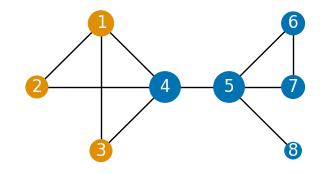

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (4,2))
nodelist = sorted(G.nodes)
nx.draw_networkx_nodes(G, pos = pos, node_color = [sns.color_palette()[suboptimal_modules[node]-1] for node in nodelist], nodelist = nodelist, node_size = [2000*suboptimal_centralities.loc[node] for node in nodelist])
nx.draw_networkx_edges(G, pos = pos)
nx.draw_networkx_labels(G, pos = pos, font_color = "white")
ax.axis("off")
plt.show()

In [16]:
# if 4 and 5 belong to the same module, we cannot identify this difference anymore
suboptimal_centralities.sort_values(ascending = False)

4    0.238732
5    0.238732
1    0.161471
6    0.132554
7    0.132554
2    0.121357
3    0.121357
8    0.069286
Name: $M_{sub}$, dtype: float64